In [1]:
# Metabolomics, Expected Competitive Interaction, and Sequential Interaction Analyses
#
# Author: Vanessa Brisson
# Copyright (C) 2024 Vanessa Brisson
#
# License: GPL

In [2]:
# IMPORT NECESSARY PACKAGES

# Data i/o and Handling
import os
import numpy as np
import pandas as pd
from collections import OrderedDict

# Statistical Analysis
from scipy import stats
from scipy import cluster
from scipy import spatial

# Plotting
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.gridspec import GridSpec
from matplotlib import colormaps
import seaborn as sns

In [3]:
# NEGATIVE IONIZATION MODE METABOLOMICS DATA

# read in the negative mode metabolomics data
neg_peakheights = pd.read_csv('MetabolomicsData/20210405_MetabCons_negative_peak-height_curated.csv')

# rename samples and drop unwanted columns
sample_long_names = list(neg_peakheights.columns[3:len(neg_peakheights.columns)])
sample_short_names = [x.split('_')[12] + '_' + x.split('_')[13] for x in sample_long_names]
neg_peakheights.rename(columns=dict(zip(sample_long_names, sample_short_names)), inplace=True)
neg_peakheights.drop(columns=['QC-PrimMet-SOPv3_IR04'], inplace=True)

# rename features
neg_peakheights.index = ['negative-' + str(x) for x in neg_peakheights['row ID']]

#transpose the data so that samples are rows and features are columns
neg_peakheights= neg_peakheights.drop(columns=['row ID', 'row m/z','row retention time']).transpose()

# extract organism IDs from the sample names
neg_peakheights['org'] = ['-'.join(x.split('_')[0].split('-')[1:]) for x in neg_peakheights.index]

# only keep features for which at least one sample group has a significant difference 
# of at least 10 fold  compared to background 
todiscard = []
for col in neg_peakheights.columns[0:-1]:
    discard = True
    for org in list(set(neg_peakheights['org'])):
        group1 = neg_peakheights[neg_peakheights['org']==org][col]
        group2 = neg_peakheights[neg_peakheights['org']=='NA-NA'][col]
        if group1.mean() > group2.mean():
            if stats.ttest_ind(group1,group2)[1] < 0.05/neg_peakheights.shape[1]:
                if group2.mean()==0 or group1.mean()/group2.mean() > 1:
                    discard = False
    if discard:
        todiscard.append(col)
neg_peakheights.drop(columns=todiscard, inplace=True)

# subtract off background
neg_peakheights = neg_peakheights - neg_peakheights.groupby('org').mean().loc['NA-NA']
neg_peakheights = neg_peakheights.drop(columns=['org'])

# normalize to maximum
neg_peakheights = neg_peakheights/neg_peakheights.max()

# create organism column
neg_peakheights['org'] = ['-'.join(x.split('_')[0].split('-')[1:]) for x in neg_peakheights.index]

neg_peakheights.sort_values('org', inplace=True)
neg_peakheights

,negative-1008,negative-1068,negative-1090,negative-1140,negative-1288,negative-1327,negative-1730,negative-1791,negative-1793,negative-1824,...,negative-833,negative-853,negative-917,negative-920,negative-933,negative-971,negative-972,negative-974,negative-977,org
SpentMed-Alcanivorax-EA2_2,0.256123,0.036554,-0.022993,0.280496,0.498027,0.366355,0.268539,0.002445,0.016444,0.739673,...,0.004151,0.168315,0.034696,0.000016,0.287505,0.000418,0.000373,0.000685,0.093431,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_1,0.615768,0.039395,0.005523,0.348988,0.520749,0.261934,0.537487,0.004020,0.012909,1.000000,...,0.007643,0.331007,0.051581,0.010537,0.582330,0.001400,0.001955,0.001325,0.076878,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_3,0.490121,0.038548,-0.000715,0.303486,0.420227,0.399605,0.428881,0.000000,0.001908,0.724228,...,0.012358,0.417955,0.062259,0.003173,0.568981,0.000541,0.000998,0.000526,0.079101,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_5,0.615898,0.053083,0.010279,0.433130,1.000000,0.230656,1.000000,0.000000,0.008708,0.786083,...,0.012462,0.429252,0.105703,0.015518,0.539717,0.000602,0.001844,0.001268,0.129786,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_4,0.610812,0.061495,0.000860,0.465206,0.901116,0.455037,0.810602,0.000000,0.002143,0.919030,...,0.013065,0.470138,0.078805,0.007346,0.697425,0.000482,0.000553,0.000551,0.116053,Alcanivorax-EA2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TxCtrl-abiotic-NA_2,0.289844,0.032610,-0.006280,0.045966,0.270203,-0.044974,0.280643,0.811080,0.579025,-0.000143,...,0.408968,0.097794,0.348237,0.361636,0.346047,0.368985,0.371966,0.357393,0.065509,abiotic-NA
TxCtrl-abiotic-NA_5,0.238337,0.026948,-0.013203,0.036079,0.280360,0.169097,0.300723,0.733465,0.417055,0.000009,...,0.394543,0.073188,0.231749,0.246470,0.242425,0.704491,0.345913,0.364825,0.045597,abiotic-NA
TxCtrl-abiotic-NA_3,0.524163,0.076299,0.012249,0.532775,0.491697,0.189982,0.479985,0.739421,0.446630,0.000104,...,0.749905,0.200423,0.739825,0.657625,0.658245,0.750308,0.846590,0.720599,0.175238,abiotic-NA
TxCtrl-abiotic-NA_11,0.627285,0.082312,0.094570,0.629809,0.539424,0.209140,0.507020,0.837728,0.473694,0.000167,...,0.838828,0.265688,0.691722,0.690494,0.794898,0.848657,0.908110,0.823344,0.219972,abiotic-NA


In [4]:
# POSITIVE IONIZATION MODE METABOLOMICS DATA

# read in the positive mode metabolomics data
pos_peakheights = pd.read_csv('MetabolomicsData/20210405_MetabCons_positive_peak-height_curated.csv')

# rename samples and drop unwanted columns
sample_long_names = list(pos_peakheights.columns[3:len(pos_peakheights.columns)])
sample_short_names = [x.split('_')[12] + '_' + x.split('_')[13] for x in sample_long_names]
pos_peakheights.rename(columns=dict(zip(sample_long_names, sample_short_names)), inplace=True)
pos_peakheights.drop(columns=['QC-PrimMet-SOPv3_IR03'], inplace=True)

# rename features
pos_peakheights.index = ['positive-' + str(x) for x in pos_peakheights['row ID']]

#transpose the data so that samples are rows and features are columns
pos_peakheights = pos_peakheights.drop(columns=['row ID', 'row m/z','row retention time']).transpose()

# extract organism IDs from the sample names
pos_peakheights['org'] = ['-'.join(x.split('_')[0].split('-')[1:]) for x in pos_peakheights.index]

# only keep features for which at least one sample group has a significant difference 
# of at least 10 fold  compared to background 
todiscard = []
for col in pos_peakheights.columns[0:-1]:
    discard = True
    for org in list(set(pos_peakheights['org'])):
        group1 = pos_peakheights[pos_peakheights['org']==org][col]
        group2 = pos_peakheights[pos_peakheights['org']=='NA-NA'][col]
        if group1.mean() > group2.mean():
            if stats.ttest_ind(group1,group2)[1] < 0.05/pos_peakheights.shape[1]:
                if group2.mean()==0 or group1.mean()/group2.mean() > 1:
                    discard = False
    if discard:
        todiscard.append(col)
pos_peakheights.drop(columns=todiscard, inplace=True)

# subtract off background
pos_peakheights = pos_peakheights - pos_peakheights.groupby('org').mean().loc['NA-NA']
pos_peakheights.drop(columns=['org'], inplace=True)

# normalize to maximum
pos_peakheights = pos_peakheights/pos_peakheights.max()

# create organism column
pos_peakheights['org'] = ['-'.join(x.split('_')[0].split('-')[1:]) for x in pos_peakheights.index]

pos_peakheights.sort_values('org', inplace=True)
pos_peakheights

,positive-1010,positive-1116,positive-1119,positive-1120,positive-1134,positive-1145,positive-1154,positive-1186,positive-1229,positive-1246,...,positive-756,positive-757,positive-7677,positive-7891,positive-797,positive-8,positive-81,positive-858,positive-981,org
SpentMed-Alcanivorax-EA2_1,0.540267,1.000000,1.000000,0.984560,1.000000,0.964627,0.932329,0.269044,0.895347,0.605239,...,0.360893,0.350031,0.775060,0.009816,0.924500,0.003400,0.020985,-0.163298,0.042988,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_2,0.403593,0.772315,0.744952,0.830112,0.956624,0.836140,1.000000,0.297027,0.261766,0.517527,...,0.245694,0.243158,0.412317,0.002322,0.320802,0.002472,0.020641,-0.097189,0.027646,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_3,0.497331,0.702365,0.745402,0.668221,0.726323,0.681179,0.617755,0.259836,0.526379,0.500827,...,0.367149,0.427238,0.656918,0.011170,0.863847,0.001509,0.015149,0.115737,0.071294,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_4,0.933447,0.861175,0.996711,1.000000,0.922786,1.000000,0.925388,0.359310,0.680925,0.772650,...,0.421850,0.636527,0.639373,0.011855,0.711857,0.001491,0.018921,0.093910,0.049902,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_5,0.795378,0.726394,0.910865,0.863967,0.752986,0.831716,0.791820,0.377443,0.660159,0.727091,...,0.446945,0.839821,0.782583,0.014738,0.875653,0.001691,0.019262,-0.170163,0.069011,Alcanivorax-EA2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TxCtrl-abiotic-NA_11,0.922694,0.000248,-0.000066,0.000219,0.000515,-0.000660,0.015238,0.329084,0.732519,0.475617,...,0.546505,0.663266,0.786746,0.791700,0.708937,0.554766,0.822853,0.874646,0.003119,abiotic-NA
TxCtrl-abiotic-NA_5,0.445154,0.000111,-0.000066,0.000098,0.003175,-0.000660,0.011445,0.259019,0.465856,0.548040,...,0.344112,0.326218,0.294635,0.501502,0.222500,0.136536,0.979042,0.496830,0.015196,abiotic-NA
TxCtrl-abiotic-NA_1,0.412253,0.000194,-0.000066,-0.000029,-0.000013,0.001668,0.008092,0.061975,0.315872,0.633670,...,0.226424,0.133923,0.212393,0.581882,0.224491,0.142417,0.850052,0.610131,0.001517,abiotic-NA
TxCtrl-abiotic-NA_9,0.421984,-0.000041,-0.000066,-0.000022,-0.000822,-0.000660,0.008532,0.062023,0.314999,0.716542,...,0.346489,0.324791,0.409104,0.671244,0.207558,0.163565,0.899223,0.510289,0.002057,abiotic-NA


In [5]:
# COMBINE METABOLOMICS DATA FROM BOTH IONIZATION MODES INTO A SINGLE DATA FRAME

peakheights = pos_peakheights.merge(neg_peakheights, left_index=True, right_index=True)
peakheights['org'] = peakheights['org_x']
peakheights.drop(columns=['org_x','org_y'], inplace=True)
peakheights = peakheights.loc[(peakheights['org'] != 'Arenibacter-7G5Y1') & 
                              (peakheights['org'] != 'Loktanella-4BL')]
peakheights['org'] = pd.Categorical(peakheights['org'],
                          categories=['Alcanivorax-EA2',
                                      'Algoriphagus-ARW1R1',
                                      'Oceanicaulis-13A1',
                                      'Labrenzia-13C1',
                                      'Marinobacter-M3-2',
                                      'Devosia-B7WZ',
                                      'Sulfitobacter-N5S',
                                      'Roseobacter-N2S',
                                      'Thallassospira-13M1',
                                      'Stappia-ARW1T',
                                      'abiotic-NA',
                                      'NA-NA'],
                          ordered=True)
peakheights = peakheights.sort_values('org')
peakheights

,positive-1010,positive-1116,positive-1119,positive-1120,positive-1134,positive-1145,positive-1154,positive-1186,positive-1229,positive-1246,...,negative-833,negative-853,negative-917,negative-920,negative-933,negative-971,negative-972,negative-974,negative-977,org
SpentMed-Alcanivorax-EA2_1,0.540267,1.000000,1.000000,0.984560,1.000000,0.964627,0.932329,0.269044,0.895347,0.605239,...,0.007643,0.331007,0.051581,0.010537,0.582330,0.001400,0.001955,0.001325,0.076878,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_2,0.403593,0.772315,0.744952,0.830112,0.956624,0.836140,1.000000,0.297027,0.261766,0.517527,...,0.004151,0.168315,0.034696,0.000016,0.287505,0.000418,0.000373,0.000685,0.093431,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_3,0.497331,0.702365,0.745402,0.668221,0.726323,0.681179,0.617755,0.259836,0.526379,0.500827,...,0.012358,0.417955,0.062259,0.003173,0.568981,0.000541,0.000998,0.000526,0.079101,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_4,0.933447,0.861175,0.996711,1.000000,0.922786,1.000000,0.925388,0.359310,0.680925,0.772650,...,0.013065,0.470138,0.078805,0.007346,0.697425,0.000482,0.000553,0.000551,0.116053,Alcanivorax-EA2
SpentMed-Alcanivorax-EA2_5,0.795378,0.726394,0.910865,0.863967,0.752986,0.831716,0.791820,0.377443,0.660159,0.727091,...,0.012462,0.429252,0.105703,0.015518,0.539717,0.000602,0.001844,0.001268,0.129786,Alcanivorax-EA2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ExCtrl-NA-NA_4,-0.004225,0.000072,-0.000066,0.000020,0.000598,-0.000660,-0.002399,-0.018479,0.019798,-0.004889,...,0.000053,-0.001782,-0.000137,0.001831,0.000000,-0.000076,-0.000068,-0.000198,-0.001524,NA-NA
ExCtrl-NA-NA_1,0.017657,-0.000052,-0.000066,0.000010,-0.000079,-0.000660,0.002340,0.003354,-0.011834,-0.028001,...,-0.000052,-0.001782,-0.000990,0.000617,0.000000,0.000009,-0.000015,0.000326,0.000648,NA-NA
ExCtrl-NA-NA_5,0.014058,-0.000020,-0.000066,0.000017,-0.000124,0.002641,0.001228,-0.018218,0.024903,0.048691,...,-0.000108,-0.001782,-0.000738,-0.003198,0.000000,-0.000026,-0.000025,-0.000198,0.000443,NA-NA
ExCtrl-NA-NA_2,-0.027652,-0.000013,0.000264,-0.000020,-0.000254,-0.000660,0.001229,0.011762,-0.021067,-0.003267,...,-0.000009,-0.001782,0.002808,-0.000661,0.000000,0.000037,0.000113,0.000268,0.000113,NA-NA


In [6]:
# ORGANISM NAMING 

# dictionary to match origninal organism IDs to final names to be diplayed
orgname = {'Sulfitobacter-N5S':'Sulfitobacter N5S',
           'Oceanicaulis-13A1':'Oceanicaulis 13A',
           'Algoriphagus-ARW1R1':'Algoriphagus ARW1R1',
           'Devosia-B7WZ':'Devosia EAB7WZ',
           'Labrenzia-13C1':'Roseibium 13C1',
           'Alcanivorax-EA2':'Alcanivorax EA2',
           'Thallassospira-13M1':'Thalassospira 13M1',
           'Stappia-ARW1T':'Stappia ARW1T',
           'Marinobacter-M3-2':'Marinobacter 3-2',
           'Roseobacter-N2S':'Amylibacter N2S'}

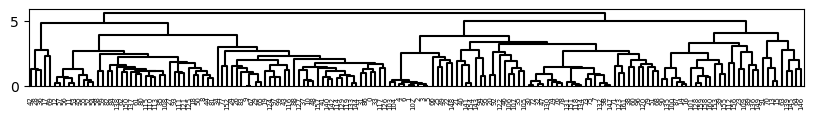

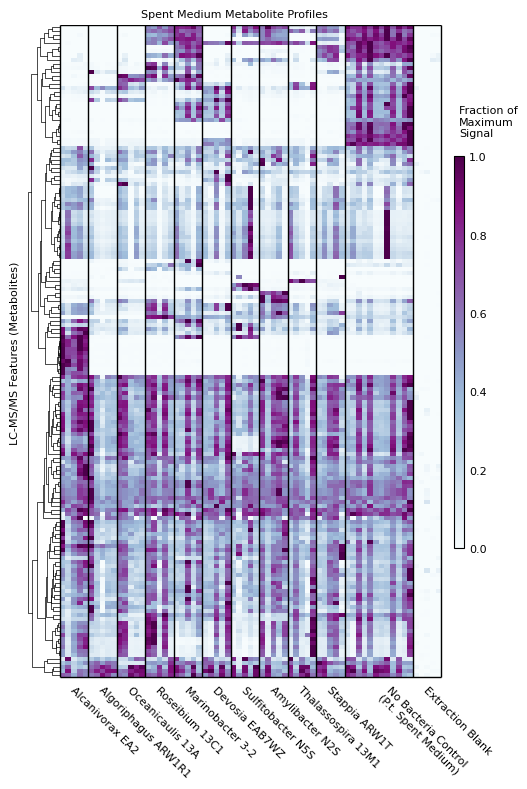

In [7]:
# SUPPLEMENTARY FIGURE S1: HEATMAP OF ALL LC-MS/MS FEATURES

hmdata1 = np.array(peakheights.select_dtypes(include=[np.number]))
hmdata2 = hmdata1.transpose()

# cluster data to group metabolites with similar patterns
plt.figure(figsize=(10,1))
Y = spatial.distance.pdist(hmdata2, metric='euclidean')
Z = cluster.hierarchy.linkage(Y, method='complete', metric='euclidean')
cluster.hierarchy.set_link_color_palette(['black'])
R2 = cluster.hierarchy.dendrogram(Z, color_threshold=np.inf)
plt.show()

# reorder data according to clustering
hmdata3 = hmdata2[R2['leaves'][0]]
for idx in R2['leaves'][1:len(R2['leaves'])]:
    hmdata3 = np.vstack((hmdata3, hmdata2[idx]))

# plot the heatmap
plt.figure(figsize=(5.5,8))
plt.pcolormesh(hmdata3, cmap='BuPu', vmin=0, vmax=1)

# add the left dendrogram
for i in range(len(R2['icoord'])):
    plt.plot(-np.array([R2['dcoord'][i][0], R2['dcoord'][i][1], R2['dcoord'][i][2], R2['dcoord'][i][3]]),
                 np.array([R2['icoord'][i][0], R2['icoord'][i][1], R2['icoord'][i][2], R2['icoord'][i][3]])/10, 
                 color='k', lw=0.5)
    
# add labels
plt.ylabel('LC-MS/MS Features (Metabolites)', fontsize=8)
plt.yticks([])
plt.xticks(np.array([2.5,7.5,12.5,17.5,22.5,27.5,32.5,37.5,42.5,47.5,56.5,64.5])-1,
           [orgname[x] for x in list(OrderedDict.fromkeys(peakheights['org']))[0:10]]+['No Bacteria Control\n(P.t. Spent Medium)', 'Extraction Blank'], 
           fontsize=8, rotation=-45, ha='left')
plt.title('Spent Medium Metabolite Profiles', fontsize=8)

# add lines and adjust limits to aid visualization
plt.vlines([0,5,10,15,20,25,30,35,40,45,50,62,67],
            0,plt.ylim()[1], colors='k', lw=1)
plt.hlines([0,162],
            0,plt.xlim()[1], colors='k', lw=1)
plt.ylim(ymin=-0.5)
plt.xlim(-6,67.5)
plt.gca().tick_params(length=0)
plt.gca().spines[['left', 'top', 'bottom','right']].set_visible(False)

# add colorbar
cbar = plt.colorbar(aspect=40, pad=0.02, shrink=0.6)
cbar.ax.tick_params(length=0, labelsize=8)
cbar.ax.set_title('Fraction of\nMaximum\nSignal\n', fontsize=8, ha='left')

# save and display the figure
plt.tight_layout()
plt.savefig('OutputFigures/SupplementaryFigure_S1.pdf', dpi=1200)
plt.show()

In [8]:
# CACULATE FOLD CHANGE FOR ALL LC-MS/MS FEATURES IN SAMPLES COMPARED TO AXENIC CONTROL 

fcdata = pd.DataFrame(columns = peakheights.columns)
newindex = []

# loop through all organisms
for org in list(set(peakheights['org'])):
    if org != 'NA-NA' and org != 'abiotic-NA':
        new_sample = {key: 0 for key in peakheights.columns[0:-1]}
        new_sample['org'] = org
        newindex.append(org)
        orgdata = peakheights.loc[neg_peakheights['org']==org]
        ctrldata = peakheights.loc[neg_peakheights['org']=='abiotic-NA']
        
        # loop through all metabolites
        for col in peakheights.columns[0:-1]:
            group1 = orgdata[col]
            group2 = ctrldata[col]
            
            # only record statistically significant fold changes, leave others at 0
            if stats.ttest_ind(group1,group2)[1] < 0.05/peakheights.shape[1]: #bonferroni correction
                
                if group1.mean() <=0 and group2.mean() <= 0: # deal with zeros in both gorups
                    new_val = 0
                elif group1.mean() <= 0: # deal with zeros in the samples from org
                    new_val = -10
                elif group2.mean() <= 0: # deal with zeros in the abiotic control
                    new_val = 10
                else:
                    new_val = np.log2(group1.mean()/group2.mean())
                    
                # set maximum to 10 and minimum to -10    
                if new_val < -10:
                    new_val = -10
                elif new_val > 10:
                    new_val = 10
                    
                new_sample[col] = new_val
        
        fcdata = pd.concat([fcdata, pd.DataFrame.from_records([new_sample])])

fcdata = fcdata.astype({x: 'float' for x in fcdata.columns[0:-1]})

# keep only features with significant fold change
fcdata = fcdata.loc[:, (fcdata != 0).any(axis=0)] # keep only features with significant fold change
fcdata.index = newindex
fcdata

C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\728296793.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fcdata = pd.concat([fcdata, pd.DataFrame.from_records([new_sample])])
C:\Users\brisson2\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,positive-1116,positive-1119,positive-1120,positive-1134,positive-1145,positive-1154,positive-1484,positive-1492,positive-1505,positive-1522,...,negative-721,negative-796,negative-822,negative-833,negative-853,negative-920,negative-971,negative-972,negative-974,org
Stappia-ARW1T,2.871813,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-7.984767,0.000000,-10.000000,...,-0.847112,0.000000,0.000000,-6.930652,0.000000,-7.005190,-7.721734,-7.847195,-7.388483,Stappia-ARW1T
Algoriphagus-ARW1R1,6.130494,10.0,7.250208,2.967868,10.0,0.000000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,0.000000,0.000000,0.000000,0.000000,-8.805549,-10.000000,-10.000000,-7.607367,Algoriphagus-ARW1R1
Devosia-B7WZ,0.000000,0.0,0.000000,0.000000,0.0,-4.138185,-9.872752,-9.032871,-9.190083,-10.000000,...,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Devosia-B7WZ
Alcanivorax-EA2,10.000000,10.0,10.000000,10.000000,10.0,6.370819,-10.000000,-7.752811,-10.000000,-8.989846,...,-10.000000,0.000000,0.000000,-5.824976,0.000000,-6.079178,-9.806237,-8.974951,-9.398487,Alcanivorax-EA2
Oceanicaulis-13A1,6.097604,10.0,7.209070,3.236233,10.0,0.000000,-10.000000,-9.395857,-10.000000,-8.491334,...,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.001119,-7.689617,-6.871035,Oceanicaulis-13A1
Sulfitobacter-N5S,5.641895,10.0,6.761742,2.730937,10.0,-1.753172,-7.958152,-8.747537,-8.720896,-9.922220,...,0.000000,0.000000,0.000000,-5.174454,0.000000,-7.770858,-8.216796,-8.384548,-7.280206,Sulfitobacter-N5S
Thallassospira-13M1,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-7.052710,-8.785910,-8.684812,-10.000000,...,-3.275050,0.000000,0.000000,-6.432851,0.000000,0.000000,-8.940783,-8.508797,-7.323537,Thallassospira-13M1
Roseobacter-N2S,6.642048,10.0,7.501273,3.556317,10.0,0.000000,-3.681394,-8.435424,-6.881806,-8.963632,...,0.000000,0.000000,0.000000,-6.254293,1.705759,-6.267840,-8.732727,-7.628425,-6.737102,Roseobacter-N2S
Marinobacter-M3-2,5.642301,10.0,6.712456,2.714469,10.0,0.000000,0.000000,-8.055970,0.000000,-10.000000,...,0.000000,1.704102,-0.918176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Marinobacter-M3-2
Labrenzia-13C1,6.039072,10.0,7.175865,2.838265,0.0,0.000000,-4.868517,-8.945963,-6.478245,-10.000000,...,-0.573359,0.000000,0.000000,-7.103619,1.904086,-6.343402,-9.288400,-8.532736,-7.027930,Labrenzia-13C1


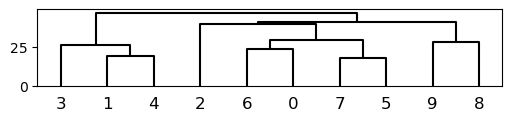

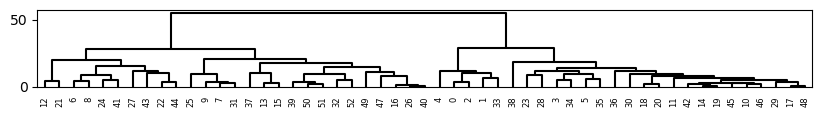

In [9]:
# GENERATED HEATMAP OF FOLD CHANGE DATA

hmdata1 = np.array(fcdata.select_dtypes(include=[np.number]))

# cluster data to group organisms with similar patterns
plt.figure(figsize=(6,1))
Y = spatial.distance.pdist(hmdata1, metric='euclidean')
Z = cluster.hierarchy.linkage(Y, method='complete', metric='euclidean', 
                              optimal_ordering=True)
cluster.hierarchy.set_link_color_palette(['black'])
R1 = cluster.hierarchy.dendrogram(Z, color_threshold=np.inf)
plt.show()

# reorder data based on clustering
hmdata2 = hmdata1[R1['leaves'][0]]
for idx in R1['leaves'][1:len(R1['leaves'])]:
    hmdata2 = np.vstack((hmdata2, hmdata1[idx]))
hmdata2 = hmdata2.transpose()

# cluster data to group metabolites with similar patterns
plt.figure(figsize=(10,1))
Y = spatial.distance.pdist(hmdata2, metric='euclidean')
Z = cluster.hierarchy.linkage(Y, method='complete', metric='euclidean')
cluster.hierarchy.set_link_color_palette(['black'])
R2 = cluster.hierarchy.dendrogram(Z, color_threshold=np.inf)
plt.show()

# reorder based on clustering
hmdata3 = hmdata2[R2['leaves'][0]]
for idx in R2['leaves'][1:len(R2['leaves'])]:
    hmdata3 = np.vstack((hmdata3, hmdata2[idx]))
hmdata3 = hmdata3.transpose()

In [10]:
# OUTPUT METABOLITE PROFILE DISTANCE MATRIX FOR MANTEL TEST

fccopy = fcdata.copy()
new_index = []
for x in fccopy.index:
    new_index.append(orgname[x])
fccopy.index = new_index
fccopy.sort_index(inplace=True)
fccopy_data = np.array(fccopy.select_dtypes(include=[np.number]))
fccopy_dist = pd.DataFrame(spatial.distance.squareform(spatial.distance.pdist(fccopy_data, metric='euclidean')))
fccopy_dist.index = fccopy.index
fccopy_dist.columns = fccopy.index
fccopy_dist.to_csv('OutputTables/MetabDist.csv')
fccopy_dist

,Alcanivorax EA2,Algoriphagus ARW1R1,Amylibacter N2S,Devosia EAB7WZ,Marinobacter 3-2,Oceanicaulis 13A,Roseibium 13C1,Stappia ARW1T,Sulfitobacter N5S,Thalassospira 13M1
Alcanivorax EA2,0.000000,22.360553,33.933036,41.737098,46.117922,26.133534,38.136661,40.194980,31.279685,36.655702
Algoriphagus ARW1R1,22.360553,0.000000,31.203156,34.058241,42.542900,19.128915,34.058673,35.549607,28.227966,31.916853
Amylibacter N2S,33.933036,31.203156,0.000000,39.122061,30.703041,34.800188,24.227939,22.843566,17.691153,29.190082
Devosia EAB7WZ,41.737098,34.058241,39.122061,0.000000,39.701216,35.611889,40.116813,36.379543,36.996404,25.985070
Marinobacter 3-2,46.117922,42.542900,30.703041,39.701216,0.000000,38.385015,28.036032,32.612872,33.591732,40.027846
Oceanicaulis 13A,26.133534,19.128915,34.800188,35.611889,38.385015,0.000000,31.840541,39.059979,33.242870,33.224517
Roseibium 13C1,38.136661,34.058673,24.227939,40.116813,28.036032,31.840541,0.000000,26.137815,28.889741,31.748001
Stappia ARW1T,40.194980,35.549607,22.843566,36.379543,32.612872,39.059979,26.137815,0.000000,26.496683,23.592528
Sulfitobacter N5S,31.279685,28.227966,17.691153,36.996404,33.591732,33.242870,28.889741,26.496683,0.000000,27.073797
Thalassospira 13M1,36.655702,31.916853,29.190082,25.985070,40.027846,33.224517,31.748001,23.592528,27.073797,0.000000


In [11]:
# LIST NUMBER OF METABOLITES CONSUMED/PRODUCED BY DIFFERENT ISOLATES

consumed = np.where(hmdata3 < 0, 1, 0).sum(axis=1)
produced = np.where(hmdata3 > 0, 1, 0).sum(axis=1)
organism = [fcdata['org'][R1['leaves'][y]] for y in np.arange(len(R1['leaves']))]
print(pd.DataFrame({'isolate':organism,'consumed':consumed,'produced':produced}))

               isolate  consumed  produced
0      Alcanivorax-EA2        27        16
1  Algoriphagus-ARW1R1        26         6
2    Oceanicaulis-13A1        24         9
3         Devosia-B7WZ        18         1
4  Thallassospira-13M1        23         1
5        Stappia-ARW1T        22         4
6      Roseobacter-N2S        22        15
7    Sulfitobacter-N5S        25        11
8       Labrenzia-13C1        21        11
9    Marinobacter-M3-2         8        12


C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\927595464.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organism = [fcdata['org'][R1['leaves'][y]] for y in np.arange(len(R1['leaves']))]


In [12]:
# ESTIMATE PROPORTION OF EACH METABOLITE CONSUMED BY EACH BACTERIAL STRAIN 
# This will be used to calculate the expected competitive interactions between strains.

pmdata = pd.DataFrame(columns = peakheights.columns)
newindex = []

# loop through the different organisms
for org in list(set(peakheights['org'])):
    
    if org != 'NA-NA' and org != 'abiotic-NA' and org != 'Loktanella-4BL' and org != 'Arenibacter-7G5Y1':
        new_sample = {key: 0 for key in peakheights.columns[0:-1]}
        new_sample['org'] = org.split('-')[1]
        newindex.append(org)
        if org == 'Marinobacter-M3-2':
            new_sample['org'] = 'M3-2'
            
        # loop through the different metabolite features
        for col in peakheights.columns[0:-1]:
            g1 = peakheights.loc[neg_peakheights['org']==org][col].mean() # metabolite level after organism growth
            g2 = peakheights.loc[neg_peakheights['org']=='abiotic-NA'][col].mean() # metabolite level in abiotic control
            if g1 < 0:
                g1 = 0
            if g2 < 0:
                g2 = 0 
            if g2 != 0:
                p = (g2-g1)/g2 # proportion used = (amount in abiotic - amount after growth) / amount in abiotic
                if p < 0:
                    p = 0
                new_sample[col] = p
        
        pmdata = pd.concat([pmdata, pd.DataFrame.from_records([new_sample])])
        
pmdata.index = newindex
pmdata

C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\3388017081.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pmdata = pd.concat([pmdata, pd.DataFrame.from_records([new_sample])])


,positive-1010,positive-1116,positive-1119,positive-1120,positive-1134,positive-1145,positive-1154,positive-1186,positive-1229,positive-1246,...,negative-833,negative-853,negative-917,negative-920,negative-933,negative-971,negative-972,negative-974,negative-977,org
Stappia-ARW1T,0,0,0,0,0.424807,0,0.359684,0,0.119604,0.106736,...,0.991803,0,0.940960,0.992216,0.359315,0.995263,0.995657,0.994032,0.597765,ARW1T
Algoriphagus-ARW1R1,0.183834,0,0,0,0.000000,0,0.428986,0.303555,0.304823,0.144139,...,0.435338,0,0.706090,0.997765,0.234256,0.999513,0.999282,0.994872,0.500802,ARW1R1
Devosia-B7WZ,0,0,0,0.680917,0.462575,0,0.943209,0.31217,0.119413,0.050755,...,0.000000,0,0.000000,0.558902,0.152786,0.058996,0.203756,0.278668,0.000000,B7WZ
Alcanivorax-EA2,0,0,0,0,0.000000,0,0.000000,0,0.000000,0.000000,...,0.982360,0,0.875423,0.985209,0.000000,0.998883,0.998013,0.998518,0.205719,EA2
Oceanicaulis-13A1,0.195488,0,0,0,0.000000,0,0.420169,0.002,0.168587,0.117211,...,0.140320,0.199344,0.626400,0.220656,0.000000,0.998048,0.995156,0.991457,0.679322,13A1
Sulfitobacter-N5S,0.113412,0,0,0,0.000000,0,0.703351,0,0.087842,0.000000,...,0.972309,0,0.950728,0.995421,0.410046,0.996639,0.997008,0.993567,0.574614,N5S
Thallassospira-13M1,0,0,0,0,0.000000,0,0.356795,0.190536,0.170412,0.095420,...,0.988425,0,0.937880,0.051854,0.303272,0.997965,0.997255,0.993757,0.054735,13M1
Roseobacter-N2S,0,0,0,0,0.000000,0,0.173310,0.16449,0.000000,0.000000,...,0.986900,0,0.857226,0.987022,0.000000,0.997649,0.994946,0.990626,0.128055,N2S
Marinobacter-M3-2,0,0,0,0,0.000000,0,0.000000,0,0.000000,0.138967,...,0.517558,0,0.894016,0.061570,0.274848,0.000000,0.131104,0.116639,0.428042,M3-2
Labrenzia-13C1,0,0,0,0,0.000000,0,0.505241,0,0.000000,0.116832,...,0.992729,0,0.946881,0.987685,0.000000,0.998401,0.997300,0.992337,0.159776,13C1


In [13]:
# CALCULATE THE EXPECTED COMPETITIVE INTERACTION (ECI) STRENGTH FOR EACH ISOLATE PAIR

ECI = np.zeros((10,10))
myorgs = ['-'.join(x.split('-')[1:]) for x in organism]
for b1 in myorgs:
    for b2 in myorgs:
        num = 0
        denom = 0
        for m in pmdata.columns[0:-1]:
            pmr = float(pmdata.loc[pmdata.org == b2][m].iloc[0])
            pmi = float(pmdata.loc[pmdata.org == b1][m].iloc[0])
            if pmr > 0:
                num +=  pmr * pmi
                denom += pmr * pmr
        if denom > 0 :
            ECI[myorgs.index(b1),myorgs.index(b2)] = - num / denom


In [14]:
# OUTPUT THE ECI TABLE

ECIdf = pd.DataFrame(ECI.transpose()).copy()
ECIdf.index = [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]]
ECIdf.columns = [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]]
ECIdf.to_csv(path_or_buf='OutputTables/ExpectedCompetition.csv')

C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\3688472183.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ECIdf.index = [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]]
C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\3688472183.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ECIdf.columns = [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]]


In [15]:
# ORGANISM ID TO NAMES 

# dictionary to match organism IDs from metabolic resource overlap (MRO) calculation to organism names
orgname2 = {'N5S': 'Sulfitobacter N5S',
             'PT13A': 'Oceanicaulis 13A',
             'ARW1R1': 'Algoriphagus ARW1R1',
             'PTEAB7WZ': 'Devosia EAB7WZ',
             'PT13C1': 'Roseibium 13C1',
             'EA2': 'Alcanivorax EA2',
             '13M1': 'Thalassospira 13M1',
             'ARW1T': 'Stappia ARW1T',
             'PT3-2': 'Marinobacter 3-2',
             'N2S': 'Amylibacter N2S'}

In [16]:
# READ IN THE METABOLIC RESOURCE OVERLAP (MRO) DATA

MRO = pd.read_csv('MRO_Data/MRO_table.txt', index_col=0)
MRO.rename(columns=orgname2, index=orgname2, inplace=True)
MRO = MRO.reindex(ECIdf.index)
MRO = MRO.reindex(columns=ECIdf.columns)

In [17]:
# ADD PUTATIVE ANNOTATIONS OF METABOLITE FEATURES

putative_annotations = {'negative-20':'Deoxyguanosine',
                        'positive-7891':'Val-Phe',
                        'positive-1492':'Val-Leu or Val-Ile',
                        'positive-21':'Thyamine',
                        'positive-31':'Guanosine',
                        'positive-37':'Phenylalanine',
                        'positive-23':'Abscisic acid'}

C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\453613303.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(-5.7, y+0.5, orgname[fcdata['org'][R1['leaves'][y]]],
C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\453613303.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xticks(np.arange(10)+0.75, [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]],
C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\453613303.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consisten

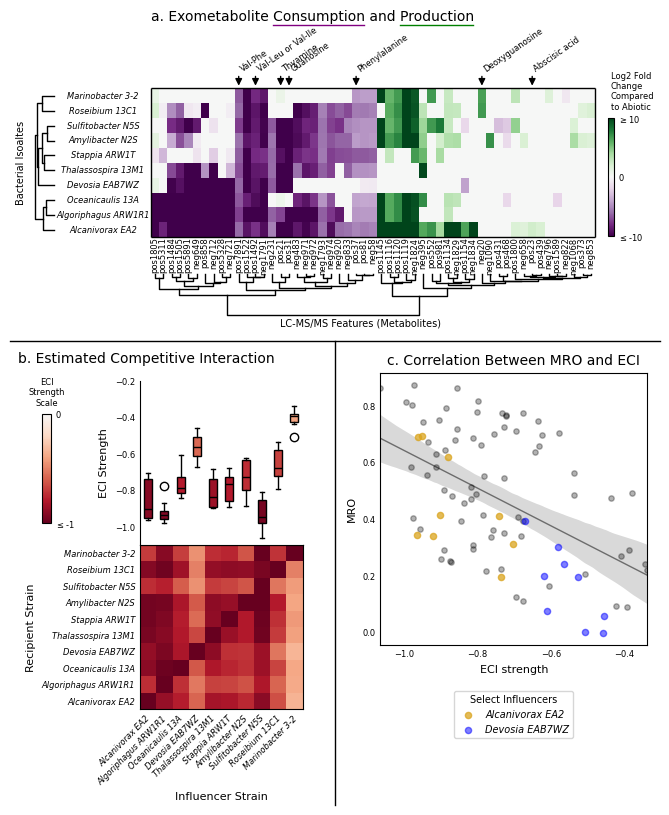

In [18]:
# FIGURE 2: METABOLITE CONSUMPTION AND PRODUCTION, ESTIMATED COMPETITIVE INTERACTIONS, AND COMPARISON TO METABOLIC RESOURCE OVERLAP

fig = plt.figure(figsize=(6.5,8))

# Part A. metabolite conumption and prduction

# setup
gs1 = GridSpec(1, 1, bottom=0.60, top=0.97, wspace=0., left=0.01, right=1.08)
ax1 = fig.add_subplot(gs1[0,0])
plt.sca(ax1)

# heatmap and colorbar
plt.pcolormesh(hmdata3, vmin=-10,vmax=10,cmap='PRGn')
cbar = plt.colorbar(aspect=20, pad=0., shrink=0.4, ticks=[-10, 0, 10], orientation = 'vertical')
cbar.ax.tick_params(length=0, labelsize=6)
cbar.ax.set_title('Log2 Fold\nChange\nCompared\nto Abiotic', fontsize=6, ha='left')
cbar.set_ticklabels([r'$\leq$'+'-10','0',r'$\geq$'+'10'])

# left dendrogram and labels (organisms)
for i in range(len(R1['icoord'])):
    plt.plot(-11.5-np.array([R1['dcoord'][i][0], R1['dcoord'][i][1], R1['dcoord'][i][2], R1['dcoord'][i][3]])/20,
                 np.array([R1['icoord'][i][0], R1['icoord'][i][1], R1['icoord'][i][2], R1['icoord'][i][3]])/10, 
                 color='k', lw=1)
plt.yticks([])
for y in np.arange(len(R1['leaves'])):
    plt.text(-5.7, y+0.5, orgname[fcdata['org'][R1['leaves'][y]]], 
             ha='center', va='center', fontsize=6,style='italic')

# bottom dendrogram and labels (features)
for i in range(len(R2['icoord'])):
    plt.plot(    np.array([R2['icoord'][i][0], R2['icoord'][i][1], R2['icoord'][i][2], R2['icoord'][i][3]])/10,
                -2.5-np.array([R2['dcoord'][i][0], R2['dcoord'][i][1], R2['dcoord'][i][2], R2['dcoord'][i][3]])/20, 
                 color='k', lw=1)
plt.xticks([])
for x in (np.arange(len(R2['leaves']))):
    plt.text(x+1, -0., [l[0:3]+l[9:] for l in fcdata.columns[R2['leaves']]][x],
             rotation=90, va = 'top', ha='right', fontsize=6)

# putative annotations 
for a in putative_annotations.keys():
    x = list(fcdata.columns[R2['leaves']]).index(a)+0.5
    plt.annotate('',(x,10), xytext=(x,11), arrowprops=dict(arrowstyle="-|>",color='k'))
    plt.text(x,11,putative_annotations[a], fontsize=6, rotation=35, va='bottom')

# finishing touches
plt.xlim(-16,54.5)
plt.ylim(-5.9,14)
plt.hlines([0,10],0,53, lw=1, color='k')
plt.vlines([0,53],0,10, lw=1, color='k')
plt.title('a. Exometabolite Consumption and Production', fontsize=10)
plt.text(25,-6,'LC-MS/MS Features (Metabolites)', fontsize=7, ha='center')
plt.text(-16,5,'Bacterial Isoaltes', fontsize=7, va='center', rotation=90)
plt.axis('off')


# Part B. Estimated competitive interactions

# setup
gs2 = GridSpec(30, 40, bottom=0.12, top=0.53, left=-0.05, right=0.45, hspace=0, wspace=0)
ax3 = fig.add_subplot(gs2[15:30,20:40]) # heatmap
ax4 = fig.add_subplot(gs2[0:15,20:40]) # influencers
ax2 = fig.add_subplot(gs2[3:13,8:9]) # colorbar
cmap = colormaps['RdBu']

# heatmap
plt.sca(ax3)
plt.pcolormesh(ECI.transpose(), cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(np.arange(10)+0.75, [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]], 
           fontsize=6,rotation=45, ha='right', style='italic')
plt.yticks(np.arange(10)+0.5, [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]],
          fontsize=6, style='italic')
ax3.tick_params(length=0)
plt.ylabel('Recipient Strain', fontsize=8)
plt.xlabel('Influencer Strain', fontsize=8)

# top (influencrs) boxplots
plt.sca(ax4)
bplot = plt.boxplot([list(ECI[x,:])[0:x] + list(ECI[x,:])[x+1:10]for x in range(10)], 
        medianprops={'color':'k'}, patch_artist=True, vert=True)
for idx in range(10):
    patch = bplot['boxes'][idx] 
    val = np.median(ECI, axis=1)[idx]
    rgba = cmap((val+1)/2)
    patch.set_facecolor(rgba)
plt.ylabel('ECI Strength', fontsize=8)
plt.ylim(-1.1,-0.2)
plt.yticks(fontsize=6)
plt.xticks([])
ax4.tick_params(length=0)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
plt.text(-7,-0.1,'b. Estimated Competitive Interaction', fontsize=10)

# colorbar
plt.sca(ax2)
cbar = plt.colorbar(shrink=0.7, orientation="vertical", fraction=0.5, cax=ax2,
                   ticks=[-1,0,1], aspect=15)
ax2.tick_params(length=0, labelsize=6)
plt.title('ECI\nStrength\nScale', fontsize=6)
plt.ylim(-1,0)
cbar.set_ticklabels([r'$\leq$'+'-1','0',r'$\geq$'+'1'])


# Part C. MRO vs ECI

# setup
gs3 = GridSpec(1,1, bottom=0.2, top=0.54, left=0.57, right=0.98, hspace=0, wspace=0)
ax5 = fig.add_subplot(gs3[0:1,0:1]) # MRO vs ECI
plt.sca(ax5)

# calculate and plot linear regression line with 95% confidence interval
np.fill_diagonal(ECIdf.values, np.nan)
np.fill_diagonal(MRO.values, np.nan)
x = np.array(ECIdf).flatten()
x = x[~np.isnan(x)]
y = np.array(MRO).flatten()
y = y[~np.isnan(y)]
reg = stats.linregress(x, y)
sns.regplot(x=x, y=y, ci=95, 
            scatter=False,
            line_kws = {'color':'k', 'lw':1, 'alpha':0.5})

# plot individual data points
for c in ECIdf.columns:
    if not(c in ['Alcanivorax EA2', 'Devosia EAB7WZ']):
        plt.scatter(ECIdf[c], MRO[c], color='k', alpha=0.3, s=15)
plt.scatter(ECIdf['Alcanivorax EA2'], MRO['Alcanivorax EA2'], 
            color='goldenrod', alpha=0.75, label='Alcanivorax EA2', s=20)
plt.scatter(ECIdf['Devosia EAB7WZ'],MRO['Devosia EAB7WZ'], 
            color='blue', alpha=0.5, label='Devosia EAB7WZ', s=20)

# add labels
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                 fontsize=7, title='Select Influencers')
for text in leg.get_texts():
    text.set_fontstyle("italic")
plt.xlim(ECIdf.min().min(), ECIdf.max().max())
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('ECI strength', fontsize=8)
plt.ylabel('MRO', fontsize=8)
plt.setp(leg.get_title(),fontsize=7)
plt.title('c. Correlation Between MRO and ECI', fontsize=10)
ax5.tick_params(length=0)


# add dividing lines between figure sections
l0 = lines.Line2D([0.405, 0.545], [0.975, 0.975], transform=fig.transFigure, figure=fig, color='purple', lw=1)
l1 = lines.Line2D([0.600, 0.713], [0.975, 0.975], transform=fig.transFigure, figure=fig, color='green', lw=1)
l2 = lines.Line2D([0, 1], [0.58, 0.58], transform=fig.transFigure, figure=fig, color='k', lw=1)
l3 = lines.Line2D([0.5, 0.5], [0, 0.58],  transform=fig.transFigure, figure=fig, color='k', lw=1)
fig.lines.extend([l0,l1,l2,l3])


#save figure
plt.savefig('OutputFigures/Figure_2.pdf', dpi=1200, transparent=False)

# display figure
plt.show()

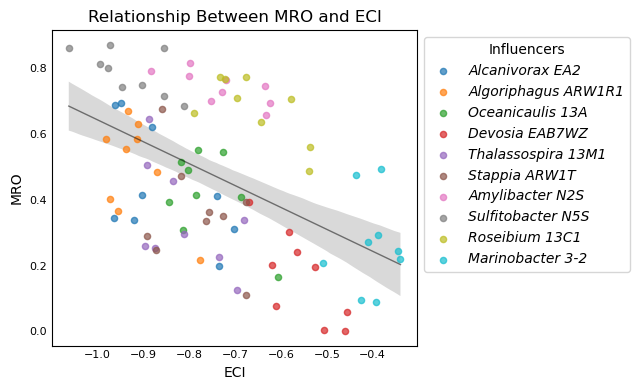

In [19]:
# FIGURE S2: MORE DETAILED COMPARISON OF ESTIMATED COMPETITIVE INTERACTIONS TO METABOLIC RESOURCE OVERLAP

plt.figure(figsize=(6.5,4))

# calculate and plot linear regressionl ine with 95% confidence intervas
reg = stats.linregress(x, y)
x = np.array(ECIdf).flatten()
x = x[~np.isnan(x)]
y = np.array(MRO).flatten()
y = y[~np.isnan(y)]
sns.regplot(x=x, y=y, ci=95, 
            scatter=False,
            line_kws = {'color':'k', 'lw':1, 'alpha':0.5})

# plot individual datapoints
for c in ECIdf.columns:
    plt.scatter(ECIdf[c], MRO[c], alpha=0.7, s=20, label=c)

# add labels
leg = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title=('Influencers'), fontsize=10)
for text in leg.get_texts():
    text.set_fontstyle("italic")
plt.gca().tick_params(length=0)
plt.xlabel('ECI', fontsize=10)
plt.ylabel('MRO', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Relationship Between MRO and ECI', fontsize=12)

# save and show figure
plt.tight_layout()
plt.savefig('OutputFigures/SupplementaryFigure_S2.pdf', dpi=1200)
plt.show()

In [20]:
# READ IN ATTUNE FLOW CYTOMETRY COUNTS FROM SEQUENTIAL SPEND MEDIUM 

attunedata = {}
attunedata['13A1'] = pd.read_csv('FlowCytometryData/13A1.csv')
attunedata['13C1'] = pd.read_csv('FlowCytometryData/13C1.csv')
attunedata['13M1'] = pd.read_csv('FlowCytometryData/13M1.csv')
attunedata['ARW1R1'] = pd.read_csv('FlowCytometryData/ARW1R1.csv')
attunedata['ARW1T'] = pd.read_csv('FlowCytometryData/ARW1T.csv')
attunedata['B7WZ'] = pd.read_csv('FlowCytometryData/B7WZ.csv')
attunedata['EA2'] = pd.read_csv('FlowCytometryData/EA2.csv')
attunedata['M3-2'] = pd.read_csv('FlowCytometryData/M3-2.csv')
attunedata['N2S'] = pd.read_csv('FlowCytometryData/N2S.csv')
attunedata['N5S'] = pd.read_csv('FlowCytometryData/N5S.csv')

In [21]:
# CALCULATE SEQUENTIAL INTERACTION (SI) STRENGTHS

interactions = {}

for b1 in myorgs:
    interactions[b1] = {}
    for b2 in myorgs:
        Gri = attunedata[b2].loc[attunedata[b2]['Group'] ==  b1  + ' SM']['CountsPerMil']
        Gr  = attunedata[b2].loc[attunedata[b2]['Group'] == 'Pt' + ' SM']['CountsPerMil']
        interactions[b1][b2] = Gri.mean() / Gr.mean() - 1
            
SI = np.zeros((len(myorgs),len(myorgs)))
for b1 in myorgs:
    for b2 in myorgs:
        SI[myorgs.index(b1),myorgs.index(b2)] = interactions[b1][b2]

C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\4033357529.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xticks(np.arange(10)+0.75, [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]],
C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\4033357529.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.yticks(np.arange(10)+0.5, [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]],


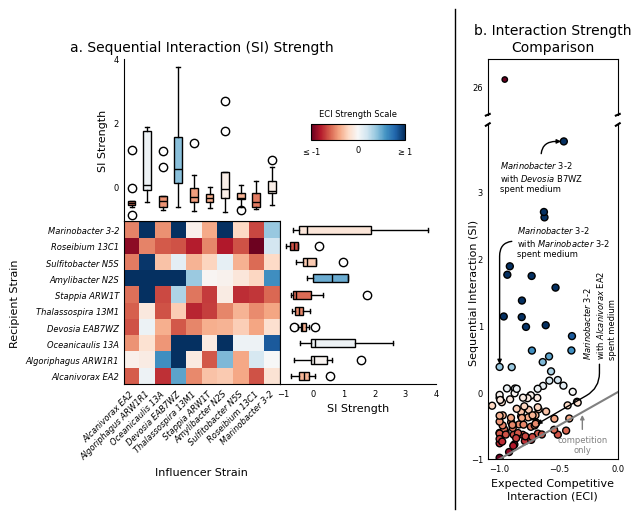

In [22]:
# FIGURE 3: SEQUENTIAL INTERACTION (SI) STRENGTHS AND COMPARISON TO EXPECTED COMPETITIVE INTERACTIONS (ECI)

fig = plt.figure(figsize=(6.5,5))

# Part A: Sequential Interactions

# setup
gs2 = GridSpec(20, 20, bottom=0.25, top=0.9, left=0.19, right=0.67, hspace=0, wspace=0)
ax2 = fig.add_subplot(gs2[4:5,12:18]) # colorbar
ax3 = fig.add_subplot(gs2[10:20,0:10])
ax4 = fig.add_subplot(gs2[0:10,0:10])
ax5 = fig.add_subplot(gs2[10:20,10:20])
cmap = colormaps['RdBu']

# heatmap
plt.sca(ax3)
plt.pcolormesh(SI.transpose(), cmap=cmap, vmin=-1, vmax=1)
plt.xticks(np.arange(10)+0.75, [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]], 
           fontsize=6,rotation=45, ha='right', style='italic')
plt.yticks(np.arange(10)+0.5, [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]],
          fontsize=6, style='italic')
ax3.tick_params(length=0)
plt.ylabel('Recipient Strain', fontsize=8)
plt.xlabel('Influencer Strain', fontsize=8)

# colorbar
plt.sca(ax2)
cbar = plt.colorbar(shrink=0.7, orientation="horizontal", fraction=0.5, cax=ax2,
                   ticks=[-1,0,1], aspect=15)
ax2.tick_params(length=0, labelsize=6)
plt.title('ECI Strength Scale', fontsize=6)
plt.xlim(-1,1)
cbar.set_ticklabels([r'$\leq$'+'-1','0',r'$\geq$'+'1'])

# top (influencer) boxplot
plt.sca(ax4)
bplot = plt.boxplot([list(SI[x,:])[0:x] + list(SI[x,:])[x+1:10]for x in range(10)], 
        medianprops={'color':'k'}, patch_artist=True, vert=True)
for idx in range(10):
    patch = bplot['boxes'][idx] 
    val = np.median(SI, axis=1)[idx]
    rgba = cmap((val+1)/2)
    patch.set_facecolor(rgba)
plt.ylabel('SI Strength', fontsize=8)
plt.ylim(-1.1,4)
plt.yticks(fontsize=6)
plt.xticks([])
ax4.tick_params(length=0)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
plt.title('a. Sequential Interaction (SI) Strength', fontsize=10)

# right (recipient) boxplot
plt.sca(ax5)
bplot = plt.boxplot([list(SI.T[x,:])[0:x] + list(SI.T[x,:])[x+1:10]for x in range(10)], 
medianprops={'color':'k'}, patch_artist=True, vert=False)
for idx in range(10):
    patch = bplot['boxes'][idx] 
    val = np.median(SI, axis=0)[idx]
    rgba = cmap((val+1)/2)
    patch.set_facecolor(rgba)
plt.xlabel('SI Strength', fontsize=8)
plt.xlim(-1.1,4)
plt.xticks([-1,0,1,2,3,4],fontsize=6)
plt.yticks([])
ax5.tick_params(length=0)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)


# Part B: SI and ECI Comparison

# setup
gs = GridSpec(2,1, height_ratios=[1,6], 
              hspace=0.05,wspace=0.4, bottom=0.1, top=0.9, left=0.75, right=0.95)
axS = fig.add_subplot(gs[1,0])
axS2 = fig.add_subplot(gs[0,0])
plt.sca(axS)

# expected composition line where SI = ECI
plt.plot([-1.1,0],[-1.1,0], color='grey')
plt.annotate("competition\nonly",
            xy=(-0.3, -0.3), xycoords='data',
            xytext=(-0.3, -0.9), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",color='grey'),
            fontsize=6, color='grey', ha='center')

# scatter plot of SI vs ECI with annotations
plt.scatter(ECI,SI, c=SI,cmap=cmap, vmin=-1, vmax=1, edgecolor='k', s=25)
plt.annotate('$\it{Marinobacter}$ 3-2\nwith $\it{Devosia}$ B7WZ\nspent medium',
            xy=(ECI[myorgs.index('B7WZ'),myorgs.index('M3-2')],SI[myorgs.index('B7WZ'),myorgs.index('M3-2')]), 
            xycoords='data',
            xytext=(-1, 3), textcoords='data', ha='left',
            arrowprops=dict(arrowstyle="-|>",color='k',
                            connectionstyle="angle,angleA=90,angleB=0,rad=15"),
            fontsize=6, color='k')
plt.annotate('$\it{Marinobacter}$ 3-2\nwith $\it{Alcanivorax}$ EA2\nspent medium',
            xy=(ECI[myorgs.index('EA2'),myorgs.index('M3-2')],SI[myorgs.index('EA2'),myorgs.index('M3-2')]), 
            xycoords='data',
            xytext=(-0.3, 0.5), textcoords='data', va='bottom', rotation=90,
            arrowprops=dict(arrowstyle="-|>",color='k',
                            connectionstyle="angle,angleA=90,angleB=30,rad=15"),
            fontsize=6, color='k')
plt.annotate('$\it{Marinobacter}$ 3-2\nwith $\it{Marinobacter}$ 3-2\nspent medium',
            xy=(ECI[myorgs.index('M3-2'),myorgs.index('M3-2')],SI[myorgs.index('M3-2'),myorgs.index('M3-2')]), 
            xycoords='data',
            xytext=(-0.85, 2), textcoords='data', va='bottom', rotation=0,
            arrowprops=dict(arrowstyle="-|>",color='k',
                            connectionstyle="angle,angleA=0,angleB=90,rad=15"),
            fontsize=6, color='k')

# add labels and adjust limits
plt.xlim(-1.1,0)
plt.ylim(-1,4)
plt.xlabel('Expected Competitive\nInteraction (ECI)', fontsize=8)
plt.ylabel('Sequential Interaction (SI)', fontsize=8, labelpad=-6)
plt.xticks([-1,-0.5,0],fontsize=6)
plt.yticks([-1,0,1,2,3],fontsize=6)
axS.tick_params(length=0)

# top axis of scatter plot
# split y axis because because one point is so far above the rest
plt.sca(axS2)

#scatter plot
plt.scatter(ECI,SI, c=SI,cmap='RdBu_r', vmin=-1, vmax=1, edgecolor='k', s=15)

# adjust limits and add title
plt.xlim(-1.1,0)
plt.ylim(25.5,26.5)
plt.xticks([])
plt.yticks([26],fontsize=6)
axS2.tick_params(length=0)
plt.title('b. Interaction Strength\nComparison', fontsize=10)
axS2.spines['bottom'].set_visible(False)
axS.spines['top'].set_visible(False)

# add diagonals indicating axis break
d = .015  # how big to make the diagonal lines in axes coordinates
axS2.plot((-d, +d), (-d, +d), transform=axS2.transAxes, color='k', clip_on=False)        # top-left diagonal
axS2.plot((1 - d, 1 + d), (-d, +d), transform=axS2.transAxes, color='k', clip_on=False)  # top-right diagonal
axS.plot((-d, +d), (1 - d/4, 1 + d/4), transform=axS.transAxes, color='k', clip_on=False)  # bottom-left diagonal
axS.plot((1 - d, 1 + d), (1 - d/4, 1 + d/4), transform=axS.transAxes, color='k', clip_on=False)  # bottom-right diagonal


# line to separate the two figure parts 
l0 = lines.Line2D([0.7, 0.7], [0, 1], transform=fig.transFigure, figure=fig, color='k', lw=1)
fig.lines.extend([l0])


# save figure
plt.savefig('OutputFigures/Figure_3.pdf', dpi=1200, transparent=False)

# display figure
plt.show()

In [23]:
# OUTPUT SI TABLE

SIdf = pd.DataFrame(SI.transpose())
SIdf.index = [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]]
SIdf.columns = [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]]
SIdf.to_csv(path_or_buf='OutputTables/SequentialInteraction.csv')
SIdf

C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\475994023.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  SIdf.index = [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]]
C:\Users\brisson2\AppData\Local\Temp\ipykernel_36508\475994023.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  SIdf.columns = [orgname[z] for z in [fcdata['org'][R1['leaves'][y]] for y in range(10)]]


,Alcanivorax EA2,Algoriphagus ARW1R1,Oceanicaulis 13A,Devosia EAB7WZ,Thalassospira 13M1,Stappia ARW1T,Amylibacter N2S,Sulfitobacter N5S,Roseibium 13C1,Marinobacter 3-2
Alcanivorax EA2,-0.609116,0.053461,-0.731445,0.533079,-0.483137,-0.293882,-0.264432,-0.384608,-0.633622,-0.144803
Algoriphagus ARW1R1,-0.052585,-0.085132,0.620939,1.561833,-0.085962,-0.620465,0.448719,-0.386234,0.171330,0.004506
Oceanicaulis 13A,-0.449867,-0.150768,-0.440634,2.611746,1.368471,-0.090795,1.735987,0.048914,0.049609,0.837125
Devosia EAB7WZ,-0.637294,0.054940,-0.362519,-0.619337,-0.488748,-0.361856,-0.346855,-0.249242,-0.397997,-0.157044
Thalassospira 13M1,-0.594343,-0.108462,-0.638473,-0.257469,-0.765229,-0.688158,-0.486502,-0.347613,-0.473627,-0.394465
Stappia ARW1T,-0.554546,1.754301,-0.660827,0.309889,-0.536569,-0.699981,-0.083410,-0.740149,-0.713446,-0.575857
Amylibacter N2S,1.130355,26.131712,1.121382,0.999695,0.372926,-0.016893,-0.041762,-0.117727,-0.212274,0.622199
Sulfitobacter N5S,-0.518411,0.974456,-0.290135,0.096238,-0.346561,-0.226299,0.092882,-0.352883,-0.563248,-0.198682
Roseibium 13C1,-0.895698,-0.497949,-0.612143,-0.635902,-0.782433,-0.491230,-0.803491,-0.635016,-0.982202,0.180226
Marinobacter 3-2,-0.498302,1.880647,-0.457198,3.747261,-0.048730,-0.377523,2.692350,-0.203397,-0.671422,0.376303
